In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor , Pool
import shap


In [11]:
df= pd.read_csv('../csv/after_cleaning/mubawab_preprocessed.csv')
df.head()

,delegation,superficie,chambres,salle_de_bains,etat,etage,gouvernorat_ariana,gouvernorat_ben-arous,gouvernorat_la-manouba,gouvernorat_tunis,prix
0,26.0,88,2,1,9,1,0.0,0.0,0.0,1.0,340000.0
1,23.0,100,2,1,9,1,0.0,0.0,0.0,1.0,135000.0
2,36.0,152,2,1,9,1,0.0,0.0,0.0,1.0,680000.0
3,36.0,120,1,1,9,1,0.0,0.0,0.0,1.0,470000.0
4,31.0,145,3,1,11,4,0.0,0.0,0.0,1.0,260000.0


**train test split**

NOTE: Gradient Boosting Machines (XGBoost, LightGBM, CatBoost) – work well without scaling, as they rely on decision trees.


In [12]:
X= df.drop(columns='prix')

y= df['prix']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# catBoost

Catboost is a high-performance gradient-boosting technique made for machine learning tasks, especially in situations involving structured input. Gradient boosting, an ensemble learning technique, forms the basis of its main workings. Catboost begins by speculating, frequently the mean of the target variable. The ensemble of decision trees is then gradually built, with each tree seeking to eliminate the errors or residuals from the previous ones. Catboost stands out because of how well it handles category features. Catboost uses a method termed “ordered boosting” to process categorical data directly, resulting in faster training and better model performance.

Additionally, regularization techniques are incorporated to avoid overfitting. Catboost integrates the predictions from all the trees when making predictions, creating models that are extremely accurate and reliable. Additionally, it offers feature relevance rankings that help with feature selection and comprehension of model choices. Catboost is a useful tool for a variety of machine-learning tasks, such as classification, regressions, etc.



In [22]:
cat = CatBoostRegressor(task_type='GPU', iterations=1000, depth=16, loss_function='RMSE') 

train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

cat.fit(train_pool, verbose=100)

y_hat= cat.predict(test_pool)

Learning rate set to 0.043081
0:	learn: 362458.2395924	total: 1.66s	remaining: 27m 36s
100:	learn: 211833.3496950	total: 17.9s	remaining: 2m 39s
200:	learn: 198146.7790843	total: 42.7s	remaining: 2m 49s
300:	learn: 192442.4148558	total: 1m 13s	remaining: 2m 50s
400:	learn: 188227.1440698	total: 1m 56s	remaining: 2m 54s
500:	learn: 187530.5235970	total: 2m 21s	remaining: 2m 20s
600:	learn: 185765.6550148	total: 2m 47s	remaining: 1m 51s
700:	learn: 182877.4145178	total: 3m 35s	remaining: 1m 31s
800:	learn: 181141.0180234	total: 4m 9s	remaining: 1m 2s
900:	learn: 180480.9058003	total: 4m 28s	remaining: 29.5s
999:	learn: 178949.2850536	total: 5m 8s	remaining: 0us


In [23]:
mae = mean_absolute_error(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mape=mean_absolute_percentage_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R²: {r2}")

Mean Absolute Error (MAE): 113856.54819130847
Root Mean Squared Error (RMSE): 191733.8601667338
Mean Squared Error (MSE): 36761873134.43663
Mean Absolute Percentage Error (MAPE): 0.27491585118077516
R²: 0.6592118236477693


**R² is around 66% , this means the model explains about 66% of the variance in apartment prices.
The higher the R², the better the model’s fit to the data.**

**feature importance**

In [15]:
print(cat.get_feature_importance(prettified=True))

               Feature Id  Importances
0              superficie    35.535010
1              delegation    35.391718
2          salle_de_bains    13.105790
3      gouvernorat_ariana     9.276600
4       gouvernorat_tunis     4.935283
5                    etat     1.033176
6                chambres     0.320586
7                   etage     0.275760
8   gouvernorat_ben-arous     0.080980
9  gouvernorat_la-manouba     0.045096


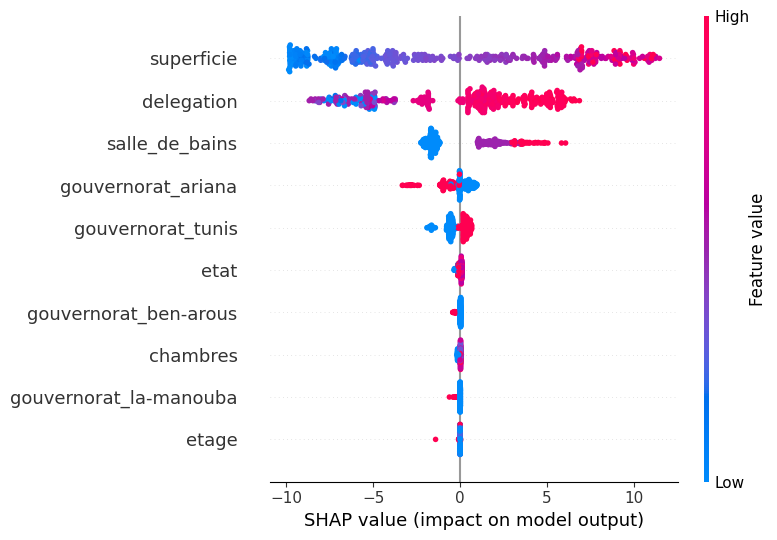

In [16]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [24]:
print(cat.get_params())


{'iterations': 1000, 'depth': 16, 'loss_function': 'RMSE', 'task_type': 'GPU'}


**learning curve**

In [30]:
# Evaluate the model using CatBoost's precision
results = cat.eval_metrics(test_pool, 
                             metrics=['RMSE', 'MAE', 'MAPE', 'R2'], 
                             plot=True)

print(results.keys())
# Plot training vs validation loss


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

dict_keys(['RMSE', 'MAE', 'MAPE', 'R2'])
